### 良品学習を用いた異常検知

開発者: Phan Hoang Phuong

2021 Mar 24

技術参考: https://keras.io/examples/generative/vae/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pickle
import tensorflow as tf
from tensorflow import keras
import time
import japanize_matplotlib

In [2]:
# check python version
!python --version

Python 3.8.0


In [3]:
# check tensorflow version
import tensorflow
print(tensorflow.__version__)

2.4.0


In [4]:
# data file paths
good_data_file_name = '../washer/good_data.pkl'
kizu_data_file_name = '../washer/kizu_data.pkl'
sabi_data_file_name = '../washer/sabi_data.pkl'
sure_data_file_name = '../washer/sure_data.pkl'

In [5]:
# reload good data
f = open(good_data_file_name, 'rb')
good_data = pickle.load(f)
f.close()

In [6]:
# reload kizu data
f = open(kizu_data_file_name, 'rb')
kizu_data = pickle.load(f)
f.close()

In [7]:
# reload sabi data
f = open(sabi_data_file_name, 'rb')
sabi_data = pickle.load(f)
f.close()

In [8]:
# reload sure data
f = open(sure_data_file_name, 'rb')
sure_data = pickle.load(f)
f.close()

In [9]:
# to normalize image data
def normalize_data(in_data):
    out_data = []
    for f in in_data:
        out_data.append(np.array(f).astype('float32') / 255)
    return np.array(out_data)

In [10]:
# normalize all data
good_data = normalize_data(good_data)
kizu_data = normalize_data(kizu_data)
sabi_data = normalize_data(sabi_data)
sure_data = normalize_data(sure_data)

In [11]:
# reload VAE
vae_encoder = tf.keras.models.load_model('../models/vae_encoder_model_mse_30')
vae_decoder = tf.keras.models.load_model('../models/vae_decoder_model_mse_30')

In [12]:
# to calculate loss
def compute_loss(data, encoder, decoder):
    z_mean, z_log_var, z = encoder(data)
    reconstruction = decoder(z)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.mse(data, reconstruction), axis=(1, 2)
        )
    )
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss

    return total_loss

# to calculate all losses
def compute_loss_list(data, encoder, decoder):

    loss_list = []

    for dt in data:
        dt = np.reshape(dt, (-1, 896, 896, 3))
        l = compute_loss(dt, encoder, decoder).numpy()
        loss_list.append(l)

    return loss_list

In [13]:
# to calculate percentage of anomaly（異常度計算）
def compute_anomaly_percent(threshold, loss):
    return f'{((loss - threshold) / threshold * 100):.2f}'


# to predict anomaly images
def predict_anomaly_images(data, encoder, decoder, threshold, image_type=False):

    # set column, row, width, height
    if len(data) == 1:
        columns = 1
        rows = 1

    else:
        columns = 5

        if len(data) % columns != 0:
            rows = round(len(data) / columns) + 1
        else:
            rows = round(len(data) / columns)

    rows = rows * 2
    width = columns * 2 + 2
    height = rows * 2 + 2

    # set figure size
    if columns == 1:
        plt.figure(figsize=(5, 5))

    else:
        plt.figure(figsize=(width, height))

    # reconstruct images
    data = np.reshape(data, (-1, 896, 896, 3))

    start_time = time.time()
    ez_mean, z_log_var, z = encoder(data)
    decoded_imgs = decoder(z)
    end_time = time.time()

    # calculate losses
    loss_list = compute_loss_list(data, encoder, decoder)

    # count anomaly images
    cnt = 0

    for i in range(len(data)):
        j = i // columns
        im = data[i]
        ax = plt.subplot(rows, columns, i+1)

        # check if anomaly
        if loss_list[i] > threshold:
            anomaly_percent = compute_anomaly_percent(threshold, loss_list[i])
            plt.title(f'異常度: {anomaly_percent}%')
            cnt += 1

        else:
            plt.title(f'Normal')

        plt.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # calculate TP, FP, TN, FN
    if not image_type:
        fp = (len(data) - cnt) / len(data) * 100
        tn = 100 - fp
        print(f'True Negative: {tn:.2f}%, False Positive: {fp:.2f}%')
    else:
        fn = cnt / len(data) * 100
        tp = 100 - fn
        print(f'True Positive: {tp:.2f}%, False Negative: {fn:.2f}%')

    # calculate time
    time_lapse = end_time - start_time
    print(f'推論時間: {time_lapse:.5f} sec')

    plt.show()

In [14]:
good_loss_list = compute_loss_list(good_data, vae_encoder, vae_decoder)
kizu_loss_list = compute_loss_list(kizu_data, vae_encoder, vae_decoder)
sabi_loss_list = compute_loss_list(sabi_data, vae_encoder, vae_decoder)
sure_loss_list = compute_loss_list(sure_data, vae_encoder, vae_decoder)

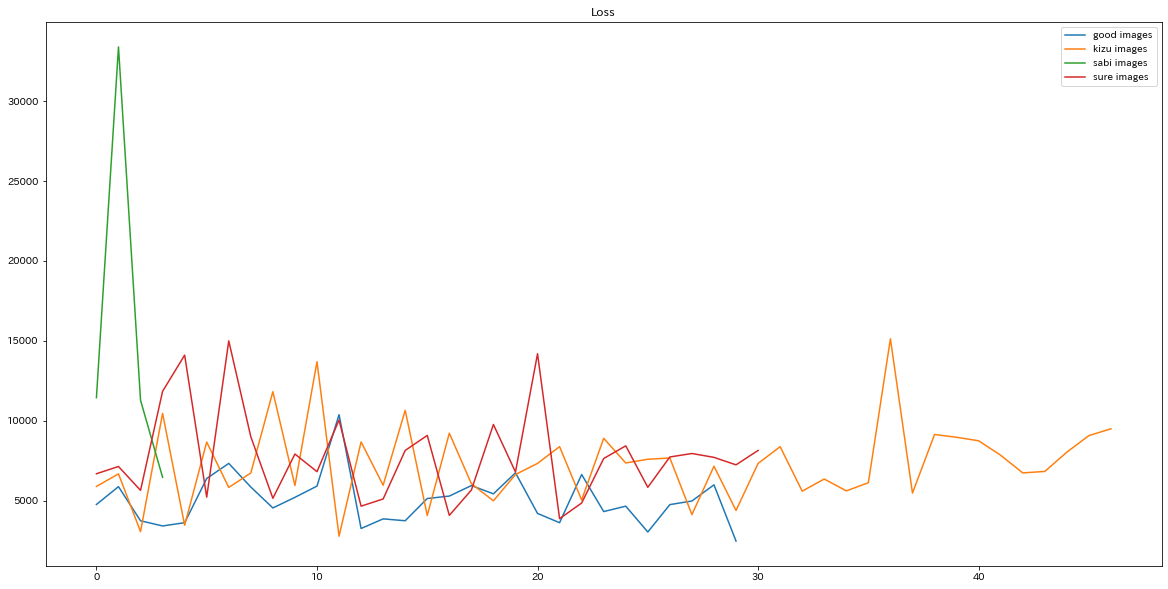

In [22]:
# plot loss list
plt.figure(figsize=(20, 10))
plt.plot(good_loss_list, label='good images')
plt.plot(kizu_loss_list, label='kizu images')
plt.plot(sabi_loss_list, label='sabi images')
plt.plot(sure_loss_list, label='sure images')
plt.title(f'Loss')
plt.legend();

In [16]:
# calculate threshold to detect anomaly image
threshold = np.mean(good_loss_list) + np.std(good_loss_list)
threshold

6593.8433

True Positive: 86.67%, False Negative: 13.33%
推論時間: 8.98509 sec


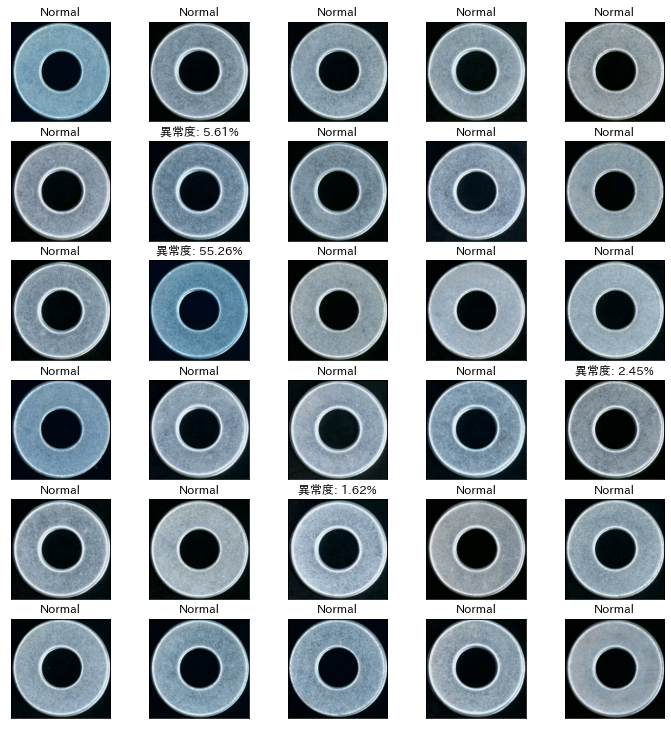

In [17]:
# test with good images
predict_anomaly_images(good_data, vae_encoder,
                       vae_decoder, threshold, image_type=True)

True Negative: 61.70%, False Positive: 38.30%
推論時間: 16.60609 sec


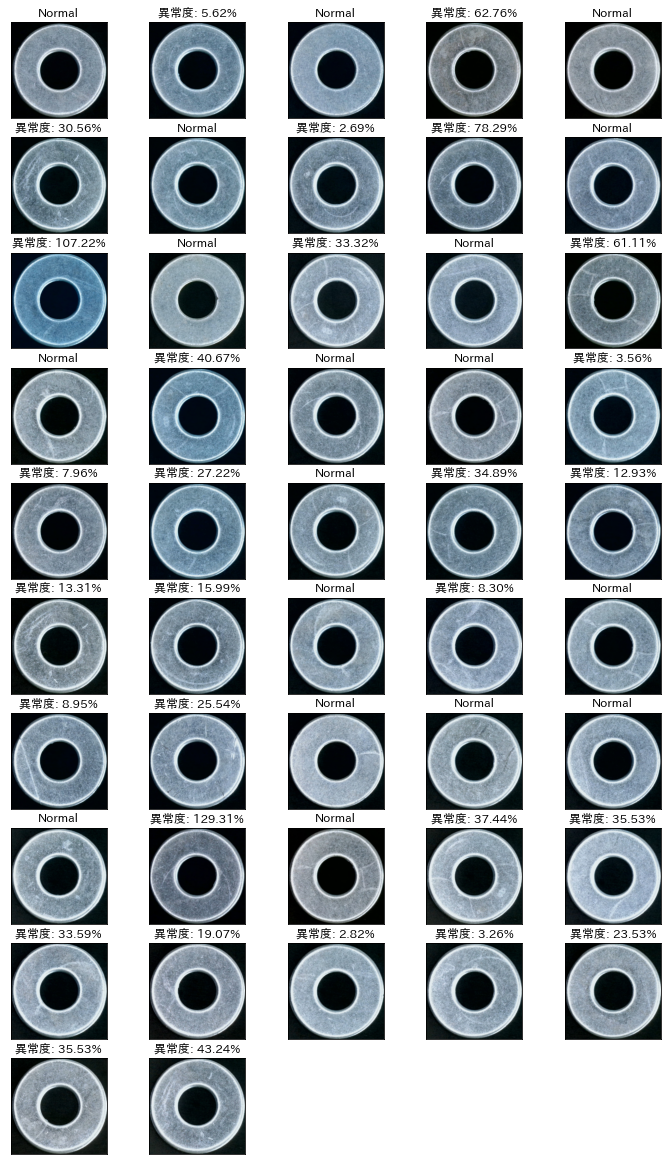

In [18]:
# test with kizu images
predict_anomaly_images(kizu_data, vae_encoder, vae_decoder, threshold)

True Negative: 75.00%, False Positive: 25.00%
推論時間: 0.99354 sec


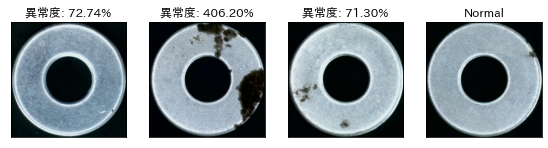

In [19]:
# test with sabi images
predict_anomaly_images(sabi_data, vae_encoder, vae_decoder, threshold)

True Negative: 64.52%, False Positive: 35.48%
推論時間: 6.37139 sec


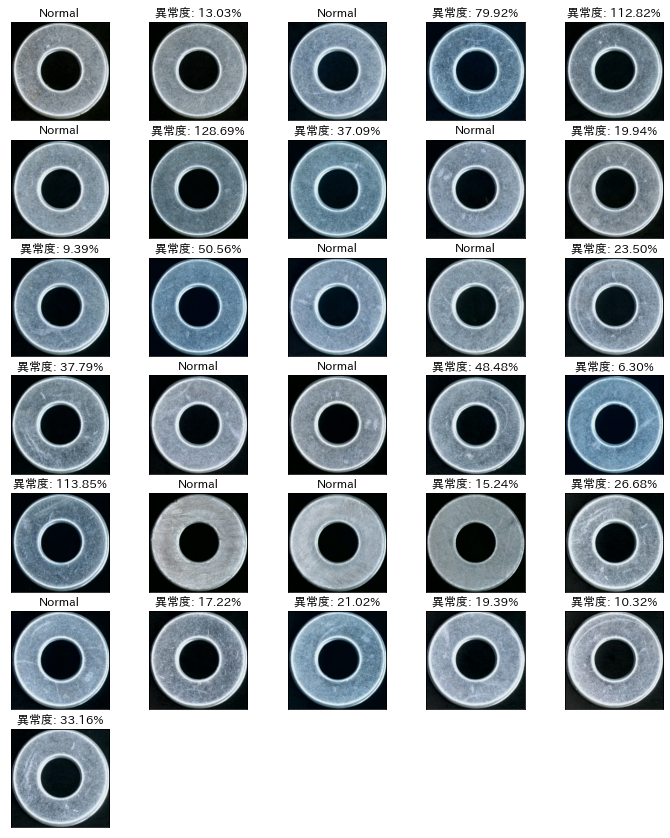

In [20]:
# test with sure images
predict_anomaly_images(sure_data, vae_encoder, vae_decoder, threshold)

True Negative: 100.00%, False Positive: 0.00%
推論時間: 0.33888 sec


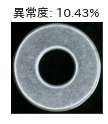

In [21]:
# test one negative image
predict_anomaly_images(sure_data[1], vae_encoder, vae_decoder, threshold)

### END